<a href="https://colab.research.google.com/github/stsmith1991/Adv_DS_libs/blob/main/property_val_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Загрузка инструментов и библиотек**

In [ ]:
#Базовые библиотеки библиотеки
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import mode
#Инструмент масштабирования
from sklearn.preprocessing import RobustScaler
#Инструмент кластеризации
from sklearn.cluster import DBSCAN
#Инструмент вспомогательный
from sklearn.neighbors import KNeighborsClassifier
#Инструмент снижения размерности
from sklearn.manifold import TSNE
#Инструмент генерации датасетов 
from sklearn.model_selection import train_test_split
#Инструмент проверки результатов
from sklearn.metrics import r2_score as r2
#прямой вывод любого постраиваемого графика
from sklearn.linear_model import LinearRegression
%matplotlib inline 

Создаю датасеты трейна и теста

In [ ]:
TRAIN_DATASET_PATH = '/kaggle/input/real-estate-price-prediction-moscow/train.csv'
TEST_DATASET_PATH = '/kaggle/input/real-estate-price-prediction-moscow/test.csv'
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TRAIN_DATASET_PATH)

1977        2652
2017         308
2016         305
2015         299
2014         210
            ... 
1928           1
1947           1
1914           1
4968           1
20052011       1
Name: HouseYear, Length: 97, dtype: int64

Находящиеся в датасете данные содеражт айди наблюдений, которые никак не могут участвовать в предсказании стоимости. Перевожу их в "безвредную" форму

In [ ]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

In [ ]:
base_sts=train_df.agg(["count", "min", "mean", "max", "median", "std"])
#Вижу излишними статысячные доли в дробных значениях. Сменяю разрядность на "до сотых":
pd.set_option('display.float_format', '{:.2f}'.format)
base_sts

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
count,10000,10000,10000.00,10000.00,7887.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000,10000,10000.00,10000.00,10000.00,5202.00,10000.00,10000.00,10000,10000.00
min,0,0,0.00,1.14,0.37,0.00,1.00,0.00,1910.00,0.00,A,A,0.00,168.00,0.00,0.00,0.00,0.00,A,59174.78
mean,inf,inf,1.89,56.32,37.20,6.27,8.53,12.61,3990.17,0.12,NaN,NaN,24.69,5352.16,8.04,1142.90,1.32,4.23,NaN,214138.86
max,9999,99,19.00,641.07,7480.59,2014.00,42.00,117.00,20052011.00,0.52,B,B,74.00,19083.00,141.00,4849.00,6.00,23.00,B,633233.47
median,8394.5,36.0,2.00,52.51,32.78,6.00,7.00,13.00,1977.00,0.08,NaN,NaN,25.00,5285.00,2.00,900.00,1.00,3.00,NaN,192269.64
std,NaN,NaN,0.84,21.06,86.24,28.56,5.24,6.78,200500.26,0.12,NaN,NaN,17.53,4006.80,23.83,1021.52,1.49,4.81,NaN,92872.29


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,out of data
0,11809,27,3.00,115.03,NaN,10.00,4,10.00,2014,0.08,...,B,11,3097,0,NaN,0,0,B,305018.87,0
1,3013,22,1.00,39.83,23.17,8.00,7,8.00,1966,0.12,...,B,30,6207,1,1183.00,1,0,B,177734.55,0
2,8215,1,3.00,78.34,47.67,10.00,2,17.00,1988,0.03,...,B,33,5261,0,240.00,3,1,B,282078.72,0
3,2352,1,1.00,40.41,NaN,1.00,10,22.00,1977,0.01,...,B,1,264,0,NaN,0,1,B,168106.01,0
4,13866,94,2.00,64.29,38.56,9.00,16,16.00,1972,0.28,...,B,33,8667,2,NaN,0,6,B,343995.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.00,49.09,33.27,6.00,3,12.00,1981,0.30,...,B,52,10311,6,NaN,1,9,B,119367.46,0
9996,16265,27,2.00,64.31,37.04,9.00,13,0.00,1977,0.07,...,B,2,629,1,NaN,0,0,A,199715.15,0
9997,2795,178,1.00,29.65,16.56,5.00,3,5.00,1958,0.46,...,B,20,4386,14,NaN,1,5,B,165953.91,0
9998,14561,21,1.00,32.33,22.33,5.00,3,9.00,1969,0.19,...,B,47,8004,3,125.00,3,5,B,171842.41,0


Работа с выпадающими данными и пропусками

In [ ]:
#Создаю новый признак out of date, характеризующий адекватность значений записи
train_df['out of data']=0
train_df.loc[(train_df['LifeSquare'].isna()) | #Наблюдения с неизвестной жилой площадью
             (train_df['Healthcare_1'].isna()) | #Наблюденя с пустым параметром здроровья №1
             (train_df['LifeSquare']>= train_df['Square']) | #Наблюдения где жилая площадь превышает общую
             (train_df['Square']<18) | #... или меньше положенного по закону
             (train_df['KitchenSquare'] >= train_df['Square']) | #где площадь кухни превышает общую
             (train_df['Floor'] > train_df['HouseFloor']) | #наблюдения где этаж превышает максимальный этаж дома
             (train_df['Floor'] >99) | #наблюдения где вместо этаж проставлен год постройки
             (train_df['HouseYear'] < 1300) | #где год проставлен неверно
             (train_df['HouseYear'] >=2021) |  #дома из будущего
             (train_df['LifeSquare']<18) | #Дома с невозможной жилой площадью
             (train_df['Social_1']>55) | #В значении 55 наблюдается "окно"
             (train_df['Social_2']>9000) | #То же
             (train_df['Healthcare_1']>2400) | #То же
             (train_df['Shops_1']>11) | #То же
             (train_df['KitchenSquare'] >= train_df['LifeSquare']), 'out of data']=1
correct=train_df.loc[(train_df['out of data']==0)]
#correct.agg(["count", "min", "mean", "max", "median", "std"])

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,out of data
count,2345,2345,2345.00,2345.00,2345.00,2345.00,2345.00,2345.00,2345.00,2345.00,...,2345,2345.00,2345.00,2345.00,2345.00,2345.00,2345.00,2345,2345.00,2345.00
min,100,0,1.00,23.58,18.00,0.00,1.00,1.00,1912.00,0.00,...,A,3.00,662.00,0.00,30.00,0.00,0.00,A,59174.78,0.00
mean,inf,inf,1.98,55.13,35.40,7.51,7.40,12.66,1982.66,0.16,...,NaN,27.21,5382.75,6.62,785.11,1.92,3.80,NaN,235075.09,0.00
max,9995,99,5.00,186.69,138.00,112.00,42.00,48.00,2020.00,0.46,...,B,47.00,8647.00,93.00,2300.00,6.00,11.00,B,624549.35,0.00
median,8527.0,53.0,2.00,50.39,32.36,8.00,6.00,12.00,1977.00,0.14,...,NaN,27.00,5613.00,2.00,645.00,2.00,4.00,NaN,209133.66,0.00
std,NaN,NaN,0.81,17.79,14.14,4.01,4.81,5.73,19.14,0.13,...,NaN,10.07,1794.36,14.63,626.19,1.53,2.75,NaN,94606.18,0.00


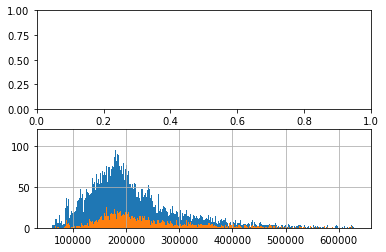

In [ ]:
#fig, ax = plt.subplots(nrows=2, ncols=1)
#ax[0]=train_df['Price'].hist(bins=500)
#ax[1]=correct['Price'].hist(bins=500)
#plt.show()

In [ ]:
#Оптимизация массива с адекватными значениями
correct=correct.drop(['Ecology_3', 'Shops_2', 'Ecology_2', 'Ecology_3'], axis = 1)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,out of data
1,3013,22,1.00,39.83,23.17,8.00,7,8.00,1966,0.12,30,6207,1,1183.00,1,0,177734.55,0
2,8215,1,3.00,78.34,47.67,10.00,2,17.00,1988,0.03,33,5261,0,240.00,3,1,282078.72,0
5,5804,99,3.00,62.53,47.10,6.00,9,9.00,1972,0.01,35,5776,1,2078.00,2,4,161044.94,0
6,8864,44,1.00,33.94,21.77,9.00,1,12.00,1968,0.23,24,4860,1,80.00,0,3,142402.74,0
7,13072,59,2.00,50.39,32.89,8.00,8,17.00,1986,0.02,37,7687,11,176.00,5,5,326174.18,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9988,1621,9,1.00,39.63,22.01,8.00,8,14.00,1990,0.16,25,5648,1,30.00,2,4,127641.21,0
9989,729,58,2.00,45.12,33.76,5.00,8,12.00,1968,0.05,24,5469,1,145.00,0,1,227361.50,0
9992,11753,37,2.00,50.90,27.16,6.00,4,9.00,1972,0.13,28,7287,5,320.00,1,3,196641.47,0
9994,4356,9,1.00,43.30,21.52,8.00,12,14.00,1992,0.16,25,5648,1,30.00,2,4,136744.34,0


После обработки отбросов необходимо произвести шкалирование

In [ ]:
scaler = RobustScaler()
colnames = correct.columns
X_train_scaled = pd.DataFrame(scaler.fit_transform(correct), columns=colnames)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,out of data
0,-0.67,-0.39,-0.50,-0.47,-0.43,0.00,0.17,-0.50,-0.35,-0.09,0.27,0.27,-0.17,0.56,-0.50,-1.00,-0.30,0.00
1,-0.04,-0.65,0.50,1.23,0.72,0.67,-0.67,0.62,0.35,-0.55,0.55,-0.16,-0.33,-0.42,0.50,-0.75,0.69,0.00
2,-0.33,0.57,0.50,0.53,0.69,-0.67,0.50,-0.38,-0.16,-0.62,0.73,0.07,-0.17,1.50,0.00,0.00,-0.46,0.00
3,0.04,-0.11,-0.50,-0.72,-0.50,0.33,-0.83,0.00,-0.29,0.48,-0.27,-0.34,-0.17,-0.59,-1.00,-0.25,-0.64,0.00
4,0.55,0.07,0.00,0.00,0.03,0.00,0.33,0.62,0.29,-0.58,0.91,0.95,1.50,-0.49,1.50,0.25,1.11,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,-0.16,-0.56,0.00,-0.23,-0.05,-1.33,0.50,-0.38,-0.13,1.60,-0.09,-0.54,-0.17,0.51,-0.50,0.25,-0.05,0.00
196,-0.62,-0.17,0.00,-0.15,-0.16,-1.00,0.00,-0.38,-0.26,1.45,-0.18,-0.28,1.00,0.09,-1.00,-0.50,-0.30,0.00
197,-0.21,-0.40,-0.50,-0.49,-0.46,0.00,-0.83,0.62,0.55,1.28,-2.18,-2.26,-0.33,-0.64,-1.00,-1.00,-0.69,0.00
198,-0.46,0.72,1.00,2.00,1.45,0.67,-0.50,0.62,0.13,-0.00,1.73,1.07,0.67,-0.31,0.50,1.75,2.32,0.00


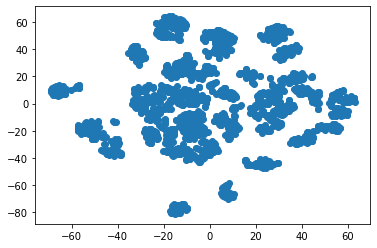

In [ ]:
tsne_model = TSNE(n_components=2, random_state=55, learning_rate=250)
redused = tsne_model.fit_transform(X_train_scaled)
plt.scatter(redused[:, 0], redused[:, 1])
plt.show()